In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

# Wasserstein distance in invasive patches molecular embedding space

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [3]:
df_summary = pd.DataFrame(columns=[
    "n_clusters", "wasserstein_distances", 
     "mean_wasserstein_distance", "std_wasserstein_distance", 
     "median_wasserstein_distance", "min_wasserstein_distance", 
     "max_wasserstein_distance", "model_type", "params"])

summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()

for model_type, names, path in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']],
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
    
    dfs = []

    for name in names:
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_raw_filtered_normalized_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv")        
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n
        n_clusters = df.shape[0]   

        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)

        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)
        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({
            "n_clusters": n_clusters, 
            "wasserstein_distances": wasserstein_distances, 
            "mean_wasserstein_distance": mean_wasserstein_distance, 
            "std_wasserstein_distance": std_wasserstein_distance, 
            "median_wasserstein_distance": median_wasserstein_distance, 
            "min_wasserstein_distance": min_wasserstein_distance, 
            "max_wasserstein_distance": max_wasserstein_distance,
            "model_type": model_type, "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names

df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


In [4]:
dfs = []
n_clusters = []

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

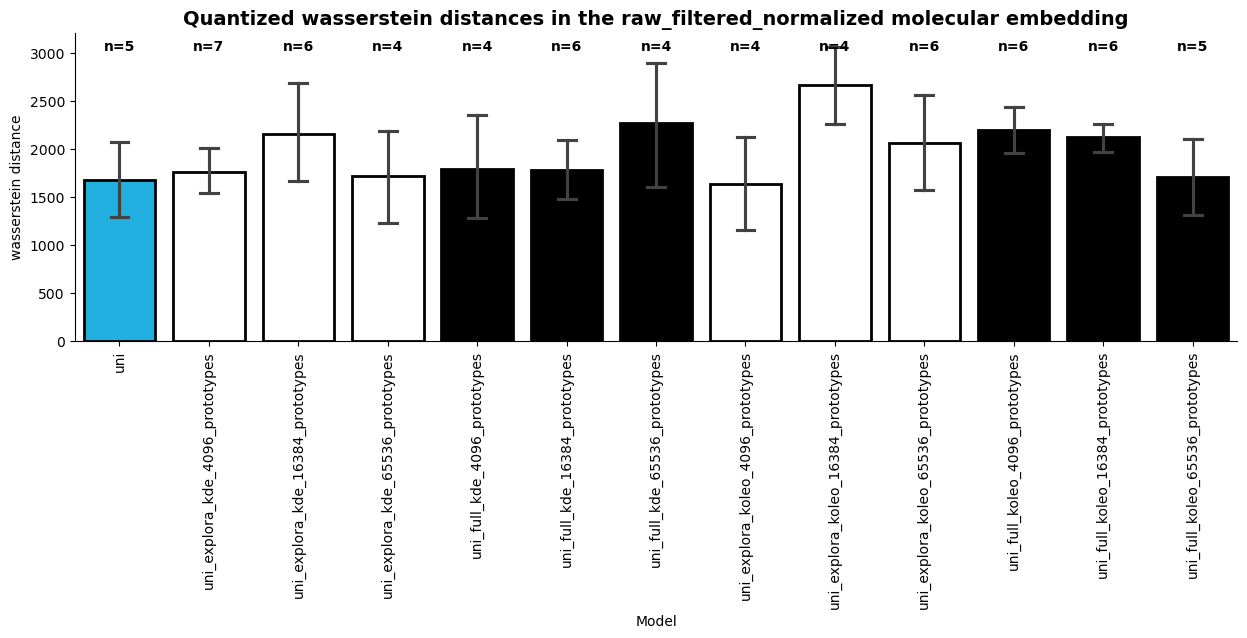

In [5]:
palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))

sns.barplot(data=df, x='model', y="wasserstein_distance", hue='model', 
            palette=palette, linewidth=2, edgecolor="black", capsize=0.2)

plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the raw_filtered_normalized molecular embedding", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=3000, s=f"n={n}", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_molecular_raw_filtered_normalized_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")